In [1]:
import matplotlib
import numpy as np
import scipy
import math
import random
import os
import time
import glob
import pandas as pd
from scipy.stats import uniform
import scipy.integrate as integrate
import scipy.special as special
from matplotlib import rcParams
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

### Spherically symmetric systems
Since the truncated sphere is not a good representation for stellar clusters we have to finde other types of potential that can be more physically relevant for our purpose. 
For this exercise we simulate a $\textbf{Plummer sphere}$.

The density distribution for the Plummer sphere is given by

$$ 
    \rho (r) = \frac{3 M_{TOT}}{4 \pi b^3} \frac{1}{( 1 + \frac{r^2}{b^2})^{\frac{5}{2}}}
$$

where $\text{b}$ is a scale radius. The density is constant in the central region, than it scales as $\frac{1}{r^5}$ for large distances from the center.

Given this mass density profile, we can compute the mass included within a radius R as: 

$$ 
    M(R) = \int_0^R 4 \pi r^2 \rho (r) dr = \dots = \frac{3 M_{tot}}{4 \pi b^3} \frac{1}{\Big(1 + \frac{r^2}{b^2}\Big)^{3/2}}
$$


The probability function for the radii is given by dividing $M(R)$ by the total mass:

$$  P(R) = \frac{M(R)}{M_{TOT}} = \frac{R^3}{b^3} \frac{1}{\Big( 1 + \frac{R^2}{b^2} \Big)^{\frac{3}{2}}} $$

By inverting this relation we can get the distribution for the radii:

$$ R = \sqrt{\frac{b^2P(R)^{2/3}}{1-P(R)^{2/3}}}  $$

For the other coordinates, we have the usual probability functions for spherical symmetry:

$$
    p(\Phi) = \frac{1}{2 \pi}  
$$

$$
    p(\Theta) = \frac{\sin{\theta}}{2}
$$

## Stability of the system

If our system is at the equilibrium we can assume that the total number of particles is unchanged, so we need a bound system which implies a negative total energy. It is also implied that the velocity dispersion should be the same in each direction due to the isotropy of the system. We need to keep into account this fact when we want to generate the velocities distribution for our system.

In order to sample our velocities we can't use the standard methods and so we have to use the $\textbf{Montecarlo rejection method}$.

## Setting the initial parameters

In [2]:
M = 1
N = 10001
m = M/N * np.ones(N)

b = 1
G = 1

# Adding Perturber
mp = 0.01*M
M += mp 
m[0] = mp # Perturber position in the array is 0

Let's sample tha radii:

In [3]:
cdf_r = uniform.rvs(0, 1, size=N)  # cumulative function of r
Rays = np.sqrt((b**2 * cdf_r**(2/3))/(1 - cdf_r**(2/3)))

Generate now the other 2 components:

In [4]:
cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas
thetas = np.arccos(1 - 2 * cdf_theta)

phis = uniform.rvs(0, 2 * np.pi, size=N) 

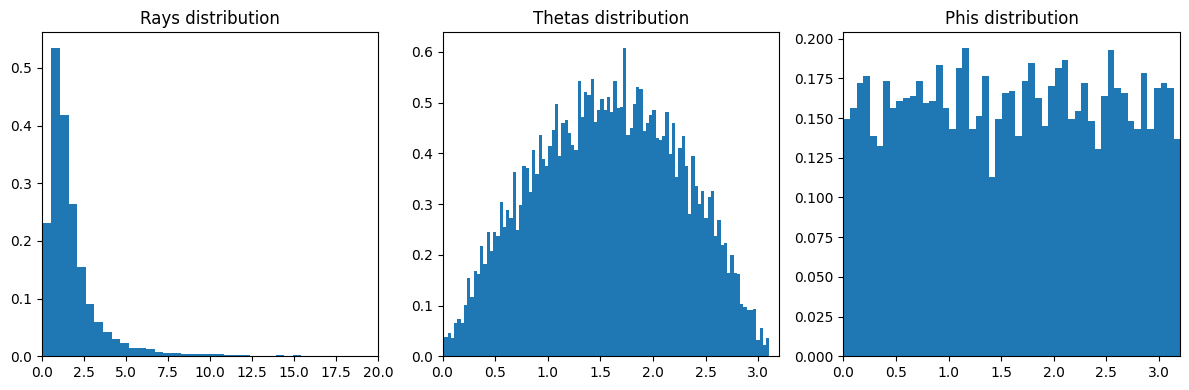

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

raggi = np.linspace(0, 20, 100)
axes[0].hist(Rays, bins=500, density=True)
axes[0].set_title("Rays distribution")
axes[0].set_xlim(0,20)


axes[1].hist(thetas, bins=100, density=True)
axes[1].set_title("Thetas distribution")
axes[1].set_xlim(0,3.2)

axes[2].hist(phis, bins=100, density=True)
axes[2].set_title("Phis distribution")
axes[2].set_xlim(0,3.2)

plt.tight_layout()


Converting now to cartesian coordinates.

In [6]:
x = Rays * np.sin(thetas) * np.cos(phis)
y = Rays * np.sin(thetas) * np.sin(phis)
z = Rays * np.cos(thetas) 


## Plot of the initial spatial distribution

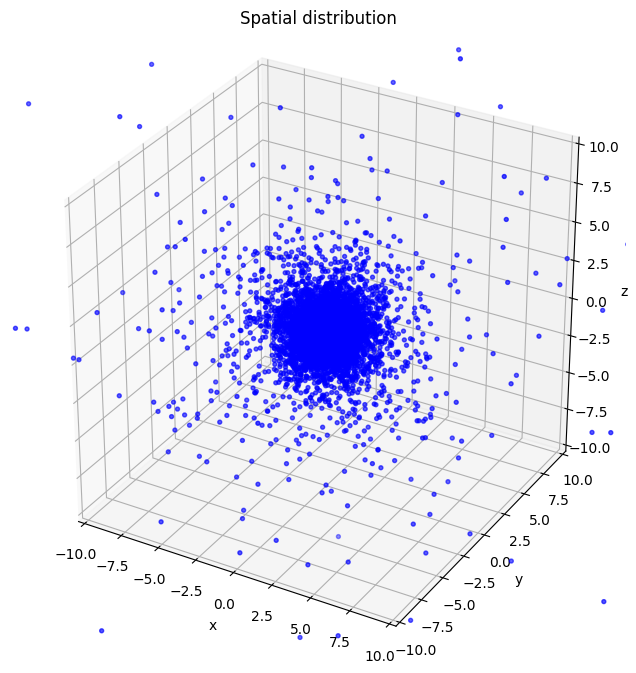

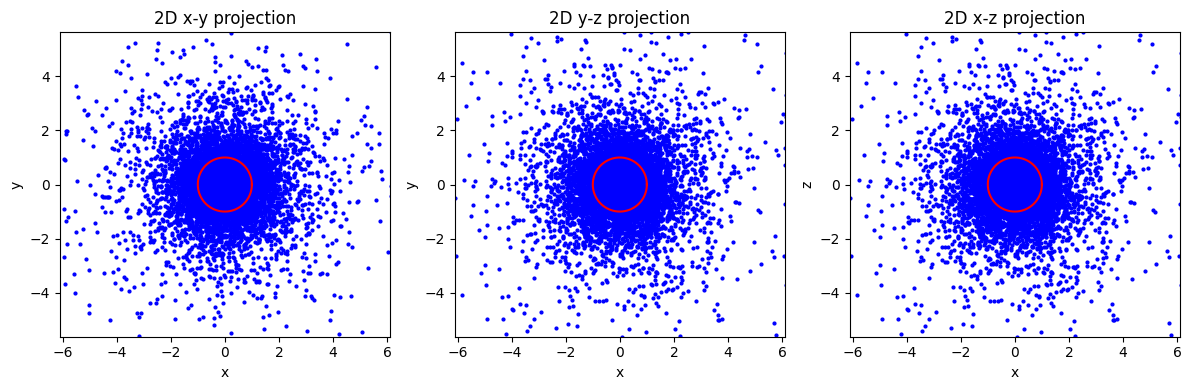

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c = 'blue', s=8)
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_title("Spatial distribution")
ax.set_box_aspect([1,1,1])

plt.show();

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)
a = b * np.cos( theta )
c = b * np.sin( theta )
axes[0].scatter(x, y, c='blue', s=4)
axes[0].plot(a, c, c='red', label='b')
axes[0].axis('equal')
axes[0].set_xlim(-5, 5)
axes[0].set_ylim(-5, 5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(y, z, c='blue', s=4)
axes[1].plot(a, c, c='red', label='b')
axes[1].axis('equal')
axes[1].set_xlim(-5, 5)
axes[1].set_ylim(-5, 5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(y, z, c='blue', s=4)
axes[2].plot(a, c, c='red', label='b')
axes[2].axis('equal')
axes[2].set_xlim(-5, 5)
axes[2].set_ylim(-5, 5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.tight_layout()
plt.show()

Now we have to set the initial conditions for the distribution of velocities. 
Given all the radii, we start by computing the potential at each radius using the analytical expression:
$$ \Psi = - \frac{1}{\sqrt{1 + \frac{r^2}{3b^2}}} $$

In [8]:
Psi = np.zeros(len(Rays))
for i in range(0,len(Rays)):
    Psi[i] = - (1 + (Rays[i])**2 / (3*b**2))**(-1/2)

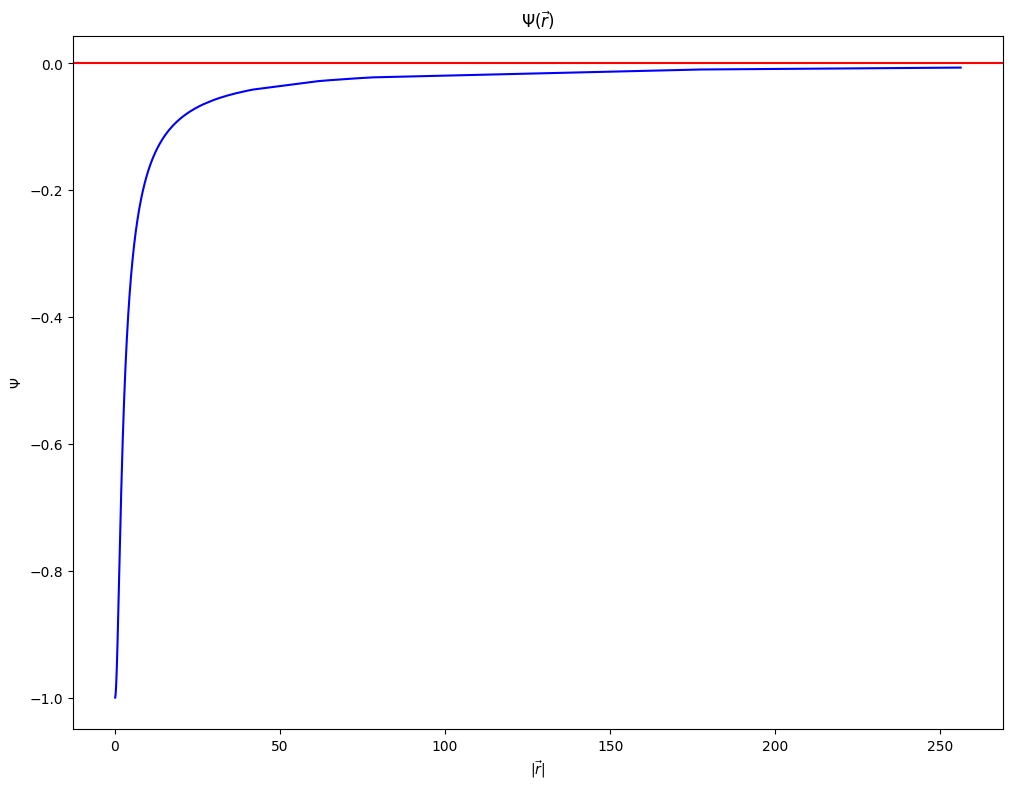

In [9]:
# Plot of the potential
plt.figure(figsize=(12,9))
plt.plot(Rays[np.argsort(Rays)], Psi[np.argsort(Rays)], c='blue')
plt.axhline(xmin=0, xmax=np.max(Rays), y=0, c='red')
plt.xlabel(r"$|\vec{r}|$")
plt.ylabel(r'$\Psi$')
plt.title(r'$\Psi(\vec{r})$')
plt.show()


In [10]:
max_pot = np.max(abs(Psi))
print(max_pot)

0.999407233144191


The cumulative function $F(\varepsilon)$ is given by:
$$ F(\varepsilon) \propto \int_0^v \Big( \Psi - \frac{v^2}{2} \Big)^{\frac{7}{2}} v^2 dv $$
And by the substitution $ q = \frac{v}{\sqrt{2\Psi}} $ we obtain:
$$ F(\varepsilon) \propto \int_0^1 ( 1- q^2 )^{\frac{7}{2}} q^2 dq $$

The new $f(q)$ found has a maximum in $q=0.471$ where it assumes the value 0.092. So we can define a new function $g(q) = 0.092$ defined in the interval [0,1]

# Applying the Montecarlo rejection method

In [11]:
import random
q_min = 0
q_max = 1 
f_max = 0.092
y_q = 1

q = np.zeros(N)
f_q = np.zeros(N)
G = 0

for i in range(0, N):
    while y_q > (1 - q[i]**2)**(7/2) * q[i]**2:
        q[i] = uniform.rvs(0,1)
        y_q = uniform.rvs(0, 0.092)
        f_q[i] = y_q
        
    #G = uniform.rvs(0,1)
    #q[i] = G / 0.092


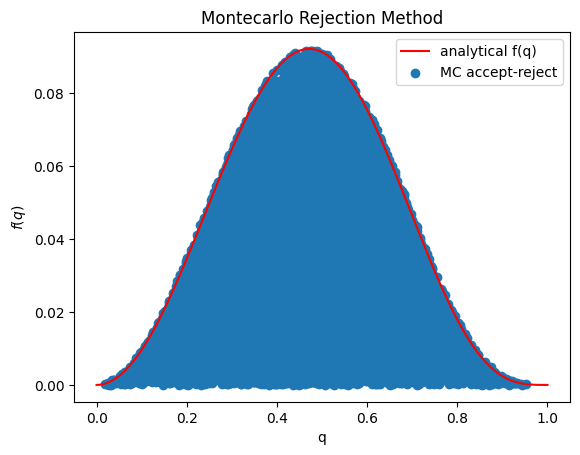

In [12]:
q_teo = np.linspace(0, 1, 1000)
plt.plot(q_teo, (1 - q_teo**2)**(7/2) * q_teo**2, color='r', label='analytical f(q)')
plt.scatter(q, f_q, label='MC accept-reject')
plt.xlabel('q')
plt.ylabel(r'$f(q)$')
plt.title('Montecarlo Rejection Method')
plt.legend()

In [13]:
velocities = q * np.sqrt(2 * -Psi)

In [14]:
theta_v = np.zeros(N)
phi_v = np.zeros(N)
v_x = np.zeros(N)
v_y = np.zeros(N)
v_z = np.zeros(N)

cdf_theta = uniform.rvs(0, 1, size=N)  # cumulative function of thetas


for i in range(0, N):
    theta_v[i] = np.arccos(1 - 2 * cdf_theta[i])
    #theta_v[i] = uniform.rvs(0, np.pi)
    phi_v[i] = uniform.rvs(0, 2*np.pi)
    
    v_x[i] = velocities[i] * np.sin(theta_v[i]) * np.cos(phi_v[i])
    v_y[i] = velocities[i] * np.sin(theta_v[i]) * np.sin(phi_v[i])
    v_z[i] = velocities[i] * np.cos(theta_v[i])
  

In [15]:
v_esc_max = np.sqrt(max_pot * 2)
print(v_esc_max)

1.413794350776796


In [16]:
rho = ((3 * M) / (4 * np.pi * b**3) ) * (1 + (Rays/b) ** 2) ** (-2.5)
tdyn = 1/np.sqrt(np.mean(rho))

print('Dynamical time:', tdyn)
print('10 * Dynamical time:', 10*tdyn)

Dynamical time: 4.785776038651768
10 * Dynamical time: 47.85776038651768


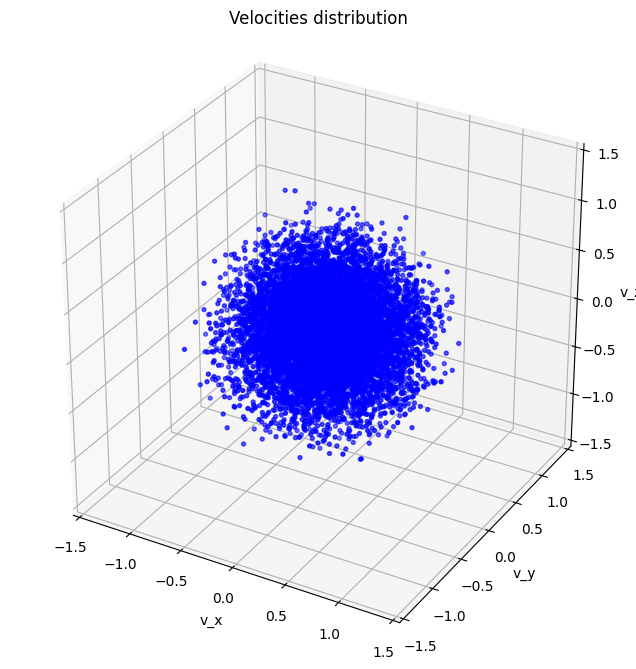

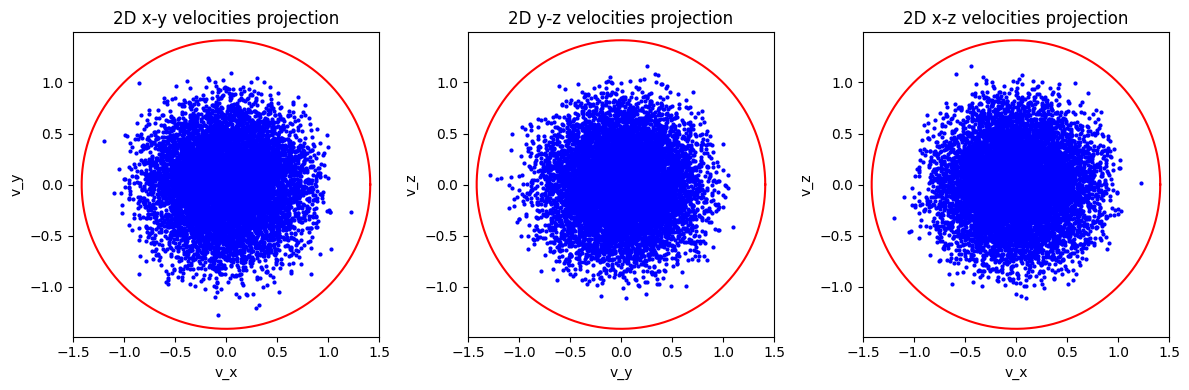

In [17]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(v_x, v_y, v_z, c = 'blue', s=8)
ax.set_aspect('equal')
ax.set_xlabel('v_x')
ax.set_ylabel('v_y')
ax.set_zlabel('v_z')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
ax.set_title("Velocities distribution")
plt.show();

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)
a = np.sqrt(2) * np.cos( theta )
c = np.sqrt(2) * np.sin( theta )
axes[0].scatter(v_x, v_y, c='blue', s=4)
axes[0].plot(a, c, c='red', label='v_esc')
axes[0].axis('equal')
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_xlabel('v_x')
axes[0].set_ylabel('v_y')
axes[0].set_title('2D x-y velocities projection')


# Projection on y-z plane
axes[1].scatter(v_y, v_z, c='blue', s=4)
axes[1].plot(a, c, c='red', label='v_esc')
axes[1].axis('equal')
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_xlabel('v_y')
axes[1].set_ylabel('v_z')
axes[1].set_title('2D y-z velocities projection')



# Projection on x-z plane
axes[2].scatter(v_x, v_z, c='blue', s=4)
axes[2].plot(a, c, c='red', label='v_esc')
axes[2].axis('equal')
axes[2].set_xlim(-1.5, 1.5)
axes[2].set_ylim(-1.5, 1.5)
axes[2].set_xlabel('v_x')
axes[2].set_ylabel('v_z')
axes[2].set_title('2D x-z velocities projection')


plt.tight_layout()
plt.show()

# Building the txt file with the initial conditions

In [18]:
x[0],y[0],z[0] = 2*b,0,0

In [19]:
# creating the input file
m_arr = m 
dim = 3


with open ('in_data.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')



# Running

In [20]:
V = 4/3*np.pi**(1/3)

In [21]:
tstop = 15*tdyn
dtime = 1/15
theta = 0.2
dtout = 1/15

In [22]:
os.system('./treecode in=in_data.txt out=output.txt dtime={} theta={} dtout={} tstop={}'.format(dtime, theta, dtout, tstop));


Hierarchical N-body code (theta scan)

   nbody     dtime       eps     theta   usequad     dtout     tstop
   10001   0.06667    0.0250      0.20     false   0.06667   71.7866

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.060   10508  33876576  15167366   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       0.000 0.11177 0.18606 0.29783 0.62473 0.00955 0.00832   0.007

	data output to file output.txt at time 0.000000

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.063   10562  34032201  15153911   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       0.067 0.11176 0.18605 0.29782 0.62472 0.00955 0.00832   0.013

	data output to file output.txt at time 0.066667

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.050   10551  34114473  15137492   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       3.400 0.11173 0.14683 0.25856 0.56787 0.00955 0.00832   0.319

	data output to file output.txt at time 3.399999

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.066   10316  32973986  15574045   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       3.467 0.11173 0.14587 0.25760 0.56626 0.00955 0.00832   0.324

	data output to file output.txt at time 3.466666

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.048   10290  32628557  15677509   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       3.533 0.11173 0.14491 0.25664 0.56465 0.00955 0.00832   0.331

	data output to file output.txt at time 3.533333

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.042   10255  32654574  15682989   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jto

       6.867 0.11174 0.11177 0.22350 0.50007 0.00955 0.00832   0.636

	data output to file output.txt at time 6.866663

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.061   10490  33669731  15363096   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       6.933 0.11174 0.11138 0.22312 0.49919 0.00955 0.00832   0.642

	data output to file output.txt at time 6.933330

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.042   10466  33295588  15506626   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       7.000 0.11174 0.11100 0.22274 0.49834 0.00955 0.00832   0.648

	data output to file output.txt at time 6.999996

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.058   10492  33499789  15455395   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
       7.067 0.11174 0.11062 0.22236 0.49750 0.00955 0.008

	data output to file output.txt at time 10.333326

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.022   10763  33743526  15430526   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      10.400 0.11174 0.10387 0.21561 0.48177 0.00955 0.00832   0.959

	data output to file output.txt at time 10.399993

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.037   10753  33801498  15358718   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      10.467 0.11174 0.10398 0.21572 0.48202 0.00955 0.00832   0.965

	data output to file output.txt at time 10.466660

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.061   10774  34202952  15178412   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      10.533 0.11173 0.10409 0.21583 0.48230 0.00955 0.00832   0.971

	data output to file output.txt at time 10.533326

	   

	data output to file output.txt at time 13.799990

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.063   10966  35750597  14419794   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      13.867 0.11174 0.10895 0.22069 0.49369 0.00955 0.00832   1.279

	data output to file output.txt at time 13.866656

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.045   10929  35767335  14340510   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      13.933 0.11174 0.10904 0.22078 0.49389 0.00955 0.00832   1.285

	data output to file output.txt at time 13.933323

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.047   10926  35713470  14413364   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      14.000 0.11174 0.10913 0.22087 0.49409 0.00955 0.00832   1.291

	data output to file output.txt at time 13.999990

	   

	data output to file output.txt at time 17.266670

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.035   10939  35452192  14456451   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      17.333 0.11174 0.11084 0.22258 0.49799 0.00955 0.00831   1.597

	data output to file output.txt at time 17.333338

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.028   10948  35462694  14476505   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      17.400 0.11174 0.11084 0.22258 0.49800 0.00955 0.00831   1.603

	data output to file output.txt at time 17.400005

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.044   10953  35565822  14433396   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      17.467 0.11173 0.11085 0.22258 0.49802 0.00955 0.00831   1.609

	data output to file output.txt at time 17.466673

	   

	data output to file output.txt at time 20.733383

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.042   10955  35980404  14194795   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      20.800 0.11174 0.11264 0.22438 0.50201 0.00955 0.00831   1.915

	data output to file output.txt at time 20.800051

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.042   10954  35989551  14209860   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      20.867 0.11174 0.11271 0.22444 0.50216 0.00955 0.00831   1.921

	data output to file output.txt at time 20.866718

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.028   10983  35913649  14304206   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      20.933 0.11174 0.11278 0.22452 0.50233 0.00955 0.00831   1.927

	data output to file output.txt at time 20.933386

	   

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.052   11153  36731523  13890959   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      24.267 0.11169 0.11254 0.22422 0.50189 0.00955 0.00831   2.233

	data output to file output.txt at time 24.266764

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.031   11184  36552649  14043065   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      24.333 0.11169 0.11242 0.22411 0.50163 0.00955 0.00831   2.239

	data output to file output.txt at time 24.333431

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.043   11154  36626754  13966387   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      24.400 0.11169 0.11230 0.22399 0.50137 0.00955 0.00831   2.245

	data output to file output.txt at time 24.400099

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.034   11021  36236384  14037197   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      27.733 0.11166 0.10766 0.21933 0.49088 0.00955 0.00831   2.550

	data output to file output.txt at time 27.733477

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.041   11072  36278738  14043561   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      27.800 0.11167 0.10764 0.21930 0.49082 0.00955 0.00831   2.556

	data output to file output.txt at time 27.800144

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.048   11086  36272155  14048841   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      27.867 0.11167 0.10762 0.21929 0.49078 0.00955 0.00831   2.562

	data output to file output.txt at time 27.866812

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      18   3.033   11043  36441167  13929637   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      31.200 0.11165 0.11143 0.22308 0.49952 0.00955 0.00831   2.867

	data output to file output.txt at time 31.200190

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.039   11069  36582012  13940042   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      31.267 0.11167 0.11146 0.22313 0.49955 0.00955 0.00831   2.873

	data output to file output.txt at time 31.266857

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.067   11069  36712776  13855167   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      31.334 0.11167 0.11147 0.22314 0.49956 0.00955 0.00831   2.879

	data output to file output.txt at time 31.333525

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      17   3.030   11040  36379843  13979667   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      34.667 0.11162 0.11166 0.22328 0.50009 0.00955 0.00831   3.184

	data output to file output.txt at time 34.666824

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      17   3.040   11011  36260456  13992474   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      34.733 0.11162 0.11163 0.22325 0.50002 0.00955 0.00831   3.190

	data output to file output.txt at time 34.733490

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.028   11014  36218641  13976737   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      34.800 0.11162 0.11159 0.22321 0.49994 0.00955 0.00831   3.196

	data output to file output.txt at time 34.800156

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.058   11074  36932062  13665047   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      38.133 0.11155 0.11356 0.22511 0.50446 0.00955 0.00831   3.501

	data output to file output.txt at time 38.133438

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.068   11056  37009057  13670170   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      38.200 0.11155 0.11363 0.22518 0.50461 0.00955 0.00831   3.507

	data output to file output.txt at time 38.200104

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.066   11057  36838998  13763584   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      38.267 0.11156 0.11370 0.22526 0.50477 0.00955 0.00831   3.513

	data output to file output.txt at time 38.266769

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.054   11047  36650758  13674617   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      41.600 0.11154 0.11231 0.22385 0.50172 0.00955 0.00831   3.817

	data output to file output.txt at time 41.600052

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.056   11026  36564904  13669548   0.007

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      41.667 0.11155 0.11228 0.22383 0.50162 0.00955 0.00831   3.824

	data output to file output.txt at time 41.666718

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.059   11016  36582810  13675106   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      41.733 0.11155 0.11224 0.22379 0.50154 0.00955 0.00831   3.830

	data output to file output.txt at time 41.733383

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.047   11064  36653381  13807933   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      45.067 0.11157 0.11197 0.22354 0.50091 0.00955 0.00832   4.131

	data output to file output.txt at time 45.066666

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.039   11033  36553187  13883149   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      45.133 0.11157 0.11197 0.22354 0.50091 0.00955 0.00832   4.136

	data output to file output.txt at time 45.133331

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.066   10997  36575933  13774013   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      45.200 0.11157 0.11197 0.22353 0.50090 0.00955 0.00832   4.143

	data output to file output.txt at time 45.199997

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.043   10970  36634420  13790683   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      48.533 0.11156 0.11258 0.22414 0.50227 0.00955 0.00832   4.444

	data output to file output.txt at time 48.533279

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.055   10982  36778536  13687358   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      48.600 0.11156 0.11263 0.22418 0.50238 0.00955 0.00832   4.450

	data output to file output.txt at time 48.599945

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.060   11040  37017970  13677639   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      48.667 0.11156 0.11266 0.22422 0.50244 0.00955 0.00832   4.456

	data output to file output.txt at time 48.666611

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.055   11071  36741332  13702281   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      52.000 0.11151 0.11339 0.22490 0.50419 0.00955 0.00832   4.757

	data output to file output.txt at time 51.999893

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.041   11058  36633035  13717907   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      52.067 0.11151 0.11339 0.22489 0.50418 0.00955 0.00832   4.763

	data output to file output.txt at time 52.066559

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      17   3.040   11031  36641813  13730757   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      52.133 0.11151 0.11338 0.22489 0.50416 0.00955 0.00832   4.769

	data output to file output.txt at time 52.133224

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.051   10975  36595348  13707942   0.005

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      55.467 0.11146 0.11322 0.22467 0.50392 0.00955 0.00832   5.071

	data output to file output.txt at time 55.466507

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.064   11021  36800669  13644319   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      55.533 0.11145 0.11320 0.22466 0.50389 0.00955 0.00832   5.077

	data output to file output.txt at time 55.533173

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.046   11055  36846011  13706038   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      55.600 0.11145 0.11319 0.22464 0.50386 0.00955 0.00832   5.084

	data output to file output.txt at time 55.599838

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.068   11039  36620807  13741235   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      58.933 0.11147 0.11010 0.22157 0.49691 0.00955 0.00832   5.384

	data output to file output.txt at time 58.933121

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.053   11021  36597666  13683808   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      59.000 0.11147 0.11004 0.22151 0.49679 0.00955 0.00832   5.391

	data output to file output.txt at time 58.999786

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.063   10995  36457245  13823818   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      59.066 0.11147 0.10999 0.22146 0.49667 0.00955 0.00832   5.397

	data output to file output.txt at time 59.066452

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.046   11032  36713219  13635486   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      62.400 0.11135 0.10888 0.22023 0.49440 0.00955 0.00832   5.701

	data output to file output.txt at time 62.399734

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.046   11062  36651883  13745985   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      62.466 0.11135 0.10887 0.22022 0.49438 0.00955 0.00832   5.707

	data output to file output.txt at time 62.466400

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.045   11091  36622138  13748271   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      62.533 0.11135 0.10887 0.22022 0.49438 0.00955 0.00832   5.713

	data output to file output.txt at time 62.533066

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.033   11123  36782257  13787830   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      65.866 0.11132 0.11000 0.22133 0.49703 0.00955 0.00832   6.018

	data output to file output.txt at time 65.866348

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.053   11177  37263810  13615637   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      65.933 0.11132 0.11005 0.22137 0.49713 0.00955 0.00832   6.024

	data output to file output.txt at time 65.933014

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      17   3.027   11165  37044741  13682648   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      66.000 0.11134 0.11009 0.22143 0.49717 0.00955 0.00832   6.030

	data output to file output.txt at time 65.999680

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.045   11069  36643631  13739332   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      69.333 0.11135 0.11173 0.22307 0.50085 0.00955 0.00832   6.334

	data output to file output.txt at time 69.332962

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      16   3.015   10997  36615721  13744104   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      69.400 0.11134 0.11181 0.22315 0.50105 0.00955 0.00832   6.340

	data output to file output.txt at time 69.399628

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.027   11018  36717165  13685104   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      69.466 0.11134 0.11189 0.22323 0.50122 0.00955 0.00832   6.346

	data output to file output.txt at time 69.466293

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot  

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.020   10986  36457618  13843639   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      71.666 0.11131 0.11315 0.22446 0.50409 0.00955 0.00832   6.548

	data output to file output.txt at time 71.666260

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.036   11039  36604632  13773768   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      71.733 0.11132 0.11319 0.22450 0.50417 0.00955 0.00832   6.554

	data output to file output.txt at time 71.732925

	   rsize  tdepth   ftree  actmax    nbbtot    nbctot   CPUfc
	   512.0      15   3.048   10998  36705052  13725222   0.006

        time   |T+U|       T      -U    -T/U  |Vcom|  |Jtot|  CPUtot
      71.800 0.11132 0.11321 0.22453 0.50420 0.00955 0.00832   6.560

	data output to file output.txt at time 71.799591


# Fetching

In [66]:
#Lettura dati
filename = glob.glob('output*')
lines = pd.read_csv(filename[0], names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3

t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])

In [67]:
x_cm = np.sum(m[1]/M*x_s, axis = 0)
y_cm = np.sum(m[1]/M*y_s, axis = 0)
z_cm = np.sum(m[1]/M*z_s, axis = 0)
r_cm = np.sqrt(x_cm**2 + y_cm**2 + z_cm**2)

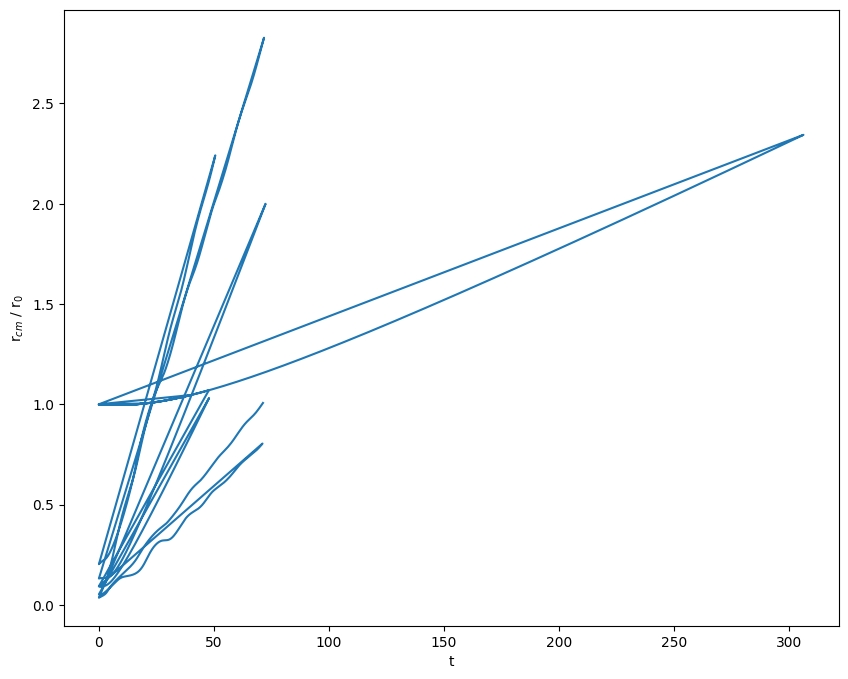

In [68]:
plt.figure(figsize=(10, 8))

plt.plot(t_s, r_cm/r_cm[0])
plt.ylabel('r$_{cm}$ / r$_{0}$')
plt.xlabel('t');

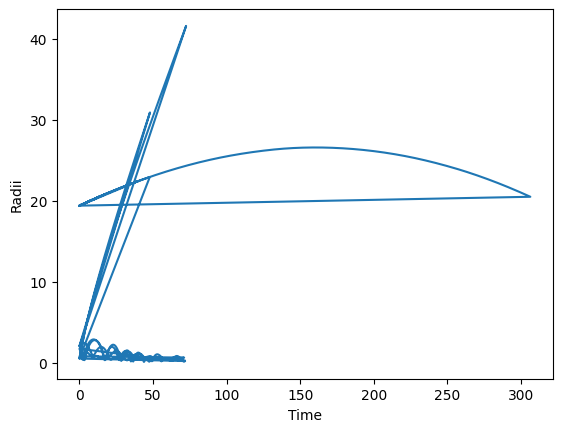

In [69]:
r = np.sqrt((x_s-x_cm)**2 + (y_s-y_cm)**2 + (z_s-z_cm)**2)

plt.plot(t_s,r[0]/b)
plt.xlabel('Time')
plt.ylabel('Radii')
plt.show()

In [33]:
# function for the animation
from matplotlib import animation

def update(num):
    N = len(m)   #N_particles
    l = 350
    ax.clear()
    
    ax.scatter(x[:,num-1], y[:,num-1], z[:,num-1], color = 'royalblue', s = 2.5 ,alpha = .3)        # Updating Point Location

    ax.set_title(f'{N} particles, mass = {m[0,0]}, time = {round(t[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)

  0%|          | 0/2781 [00:00<?, ?it/s]

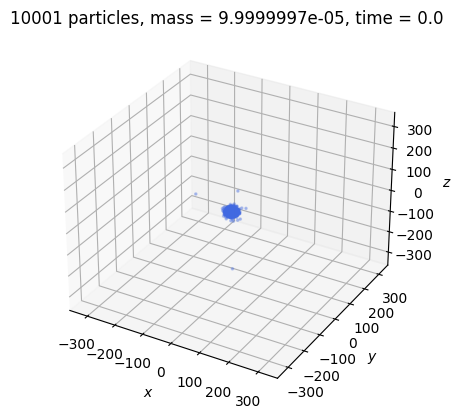

In [26]:
## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='auto')
line_ani = animation.FuncAnimation(fig, update, interval=1,   
                                   frames=tqdm(range(len(t))))

# Saving the Animation
f = fr"plummer_sphere.gif"
writergif = animation.PillowWriter(fps=30)
line_ani.save(f, writer=writergif, dpi=300)

In [70]:
radii = (x_s**2+y_s**2+z_s**2)

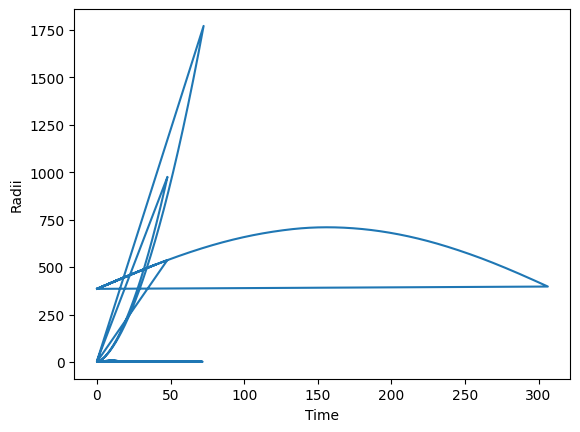

In [75]:
plt.plot(t_s,radii[0,:])
plt.xlabel('Time')
plt.ylabel('Radii')
plt.show()